In [1]:
# Import Packages 
import pandas as pd
from pandas.core.common import flatten
import numpy as np
from numpy.random import seed
from math import sqrt
import matplotlib.pyplot as plt
import statistics
from scipy.stats import uniform, randint 
from scipy.stats.mstats import winsorize

import sklearn
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score, KFold
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
#from sklearn.datasets import make_regression
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import regularizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, BatchNormalization, Dropout, AlphaDropout

import keras_tuner
from keras_tuner import Objective
from tensorflow.keras.callbacks import EarlyStopping

seed(10)
np.random.seed(10)
tf.random.set_seed(10)

In [2]:
# Create Functions for Evaluation

def mse(actual_ret, pred_ret):
    d = (actual_ret - pred_ret)**2
    mse = sum(d) / len(d)
    return mse


def mae(actual_ret, pred_ret):
    d = (actual_ret - pred_ret)
    mae = sum(abs(d)) / len(d)
    return mae
    
def rmse(actual_ret, pred_ret):
    d = (actual_ret - pred_ret)**2
    mse = sum(d) / len(d)
    rmse = sqrt(mse)
    return rmse

def r_sq(actual_ret, pred_ret):
    nom = sum((actual_ret - pred_ret)**2)
    denom = sum(actual_ret**2) # Note that R2 is demeaned
    r_sq = (1 - (nom / denom)) * 100
    return r_sq

# Calculate the percentage of correct sign predictions
def pcp(actual_ret, pred_ret):
    num_correct = sum((pred > 0) == (actual > 0) for pred, actual in zip(pred_ret, actual_ret))
    pcp = (num_correct / len(pred_ret)) * 100
    return pcp

In [330]:
# Specify the Models: We are iterating each algorithm through these four models

# To select the target variable e.g., find target variable in train set or test set
def find_target(df):
    df = df.reset_index(drop=True)
    target = df['ret+1']
    return target

# To select the predictors from the baseline model which excludes sentiment 
def find_baseline(df):
    df = df.reset_index(drop=True)
    baseline = df[['cshoc', 'cshtrd', 'eps', 'prccd', 'prchd', 'prcld', 'prcod', 'div']]
    return baseline

# To select the predictors from the Model 1 which includes the sentiment from Twitter 
def find_model_1(df):
    df = df.reset_index(drop=True)
    model_1 = df[['cshoc', 'cshtrd', 'eps', 'prccd', 'prchd', 'prcld', 'prcod', 'div', 'tweets_sent']]
    return model_1

# To select the predictors from the Model 2 which includes the sentiment from News Articles
def find_model_2(df):
    df = df.reset_index(drop=True)
    model_2 = df[['cshoc', 'cshtrd', 'eps', 'prccd', 'prchd', 'prcld', 'prcod', 'div', 'news_sent']]
    return model_2

# To select the predictors from the Model 3 which includes the sentiment from News Articles
def find_model_3(df):
    df = df.reset_index(drop=True)
    model_3 = df[['cshoc', 'cshtrd', 'eps', 'prccd', 'prchd', 'prcld', 'prcod', 'div', 'tweets_sent', 'news_sent']]
    return model_3

# Create list of functions
models_functions = [find_baseline, find_model_1, find_model_2, find_model_3] 

In [4]:
# Load Tweets
df = pd.read_csv("ml_df.csv", lineterminator='\n')

# Sort Observations 
df = df.sort_values(['date', 'company'])

count    16320.000000
mean        -0.009796
std          4.730521
min       -302.139417
1%          -7.238147
25%         -1.104501
50%          0.088598
75%          1.280240
99%          7.325540
max         20.930742
Name: ret+1, dtype: float64


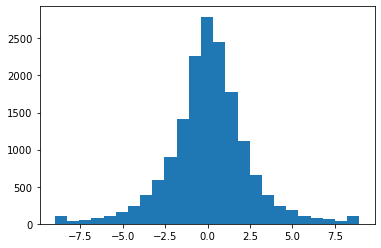

In [5]:
# Shows the extreme values in target variable
print(df['ret+1'].describe([0.01, 0.25, 0.5, 0.75, 0.99]))

# Winsorize extreme returns to reduce skewness and effect of outliers
for v in ['ret+1']:
    df[v] = winsorize(df[v],limits=[.005, .005])

# Shows distribution of returns after winsorization
plt.hist(df['ret+1'], 25)
plt.show()

# Set date as index to slice dataframe 
df = df.set_index(['date', 'company'])

# Split Data into Train and Test Set
train = df['2021-01-01':'2022-08-31']
test = df['2022-09-01':'2023-03-20']

In [6]:
# Baseline Model: Linear Regression
models_functions = [find_baseline, find_model_1, find_model_2, find_model_3] 
lr_pred = [] # To save the predictions of each models into a list

for mod in models_functions:
    model = LinearRegression().fit(mod(train), find_target(train)) 

    pred = model.predict(mod(test))
    lr_pred.append(pred)

In [7]:
# Results for Baseline Model
for i in range(0, 4):
    print("r2:", round(r_sq(find_target(test), lr_pred[i]), 4))
    print("mse:", round(mse(find_target(test), lr_pred[i]), 4))
    print("rmse:", round(rmse(find_target(test), lr_pred[i]), 4))
    print("mae:", round(mae(find_target(test), lr_pred[i]), 4))
    print("pcp:", round(pcp(find_target(test), lr_pred[i]), 4))
    print()

r2: -0.0817
mse: 6.1579
rmse: 2.4815
mae: 1.7954
pcp: 50.438

r2: -0.1358
mse: 6.1612
rmse: 2.4822
mae: 1.796
pcp: 48.8321

r2: -0.0993
mse: 6.159
rmse: 2.4817
mae: 1.7959
pcp: 49.854

r2: -0.1528
mse: 6.1622
rmse: 2.4824
mae: 1.7965
pcp: 48.3212



In [158]:
# Random Forest
rf_pred = []

for mod in models_functions:
    
    parameters = {'n_estimators': [100, 200, 300, 400],
                  'max_depth': randint(300, 350),
                  'min_samples_leaf': randint(1, 50),
                  'max_leaf_nodes': randint(5, 15)}
     
    randm_src = RandomizedSearchCV(RandomForestRegressor(),
                                   param_distributions = parameters, 
                                   scoring = 'neg_mean_squared_error',
                                   n_iter = 30,
                                   n_jobs = -1, 
                                   refit = True, 
                                   random_state = 0,
                                   return_train_score = True,
                                   cv = 5,
                                   error_score = 'raise')
    
    model = randm_src.fit(mod(train), find_target(train))
    
    print(" Results from Random Search ")
    print("\n The best estimator across ALL searched params:\n", randm_src.best_estimator_)
    print("\n The best score across ALL searched params:\n", randm_src.best_score_)
    print("\n The best parameters across ALL searched params:\n", randm_src.best_params_)

    pred = model.predict(mod(test))
    rf_pred.append(pred)

 Results from Random Search 

 The best estimator across ALL searched params:
 RandomForestRegressor(max_depth=316, max_leaf_nodes=8, min_samples_leaf=6,
                      n_estimators=300)

 The best score across ALL searched params:
 -4.987470998795036

 The best parameters across ALL searched params:
 {'max_depth': 316, 'max_leaf_nodes': 8, 'min_samples_leaf': 6, 'n_estimators': 300}
 Results from Random Search 

 The best estimator across ALL searched params:
 RandomForestRegressor(max_depth=315, max_leaf_nodes=5, min_samples_leaf=19,
                      n_estimators=400)

 The best score across ALL searched params:
 -4.988925968380372

 The best parameters across ALL searched params:
 {'max_depth': 315, 'max_leaf_nodes': 5, 'min_samples_leaf': 19, 'n_estimators': 400}
 Results from Random Search 

 The best estimator across ALL searched params:
 RandomForestRegressor(max_depth=314, max_leaf_nodes=8, min_samples_leaf=13,
                      n_estimators=200)

 The best scor

In [159]:
# Results for Random Forest
for i in range(0, 4):
    print("r2:", round(r_sq(find_target(test), rf_pred[i]), 4))
    print("mse:", round(mse(find_target(test), rf_pred[i]), 4))
    print("rmse:", round(rmse(find_target(test), rf_pred[i]), 4))
    print("mae:", round(mae(find_target(test), rf_pred[i]), 4))
    print("pcp:", round(pcp(find_target(test), rf_pred[i]), 4))
    print()

r2: 0.1967
mse: 6.1407
rmse: 2.4781
mae: 1.793
pcp: 51.6423

r2: 0.1875
mse: 6.1413
rmse: 2.4782
mae: 1.7925
pcp: 51.5693

r2: 0.2518
mse: 6.1373
rmse: 2.4774
mae: 1.7919
pcp: 51.7883

r2: 0.2158
mse: 6.1396
rmse: 2.4778
mae: 1.7928
pcp: 51.2774



In [203]:
# Gradient Boosting Regression Tree
gbrt_pred = []

for mod in models_functions: 
    parameters = {'n_estimators': [100, 200, 300, 400],
                  'max_depth':  randint(100, 200),
                  'min_samples_leaf': randint(1, 20),
                  'max_leaf_nodes': randint(20, 50),
                  'learning_rate': [0.01, 0.005]
                 }
    
    random_search = RandomizedSearchCV(GradientBoostingRegressor(),
                                       param_distributions = parameters,
                                       scoring = 'neg_mean_squared_error',
                                       n_iter = 30,
                                       n_jobs = -1,
                                       refit = True,
                                       random_state = 0,
                                       return_train_score = True,
                                       cv = 5,
                                       error_score = 'raise')
        
    model = random_search.fit(mod(train), find_target(train))
        
    print(" Results from Random Search ")
    print("Best estimator: ", random_search.best_estimator_)
    print("Best parameters: ", random_search.best_params_)
    print("Best score: ", random_search.best_score_)

    pred = model.predict(mod(test))
    gbrt_pred.append(pred)

 Results from Random Search 
Best estimator:  GradientBoostingRegressor(learning_rate=0.005, max_depth=177, max_leaf_nodes=28,
                          min_samples_leaf=10)
Best parameters:  {'learning_rate': 0.005, 'max_depth': 177, 'max_leaf_nodes': 28, 'min_samples_leaf': 10, 'n_estimators': 100}
Best score:  -4.99324924813404
 Results from Random Search 
Best estimator:  GradientBoostingRegressor(learning_rate=0.005, max_depth=177, max_leaf_nodes=28,
                          min_samples_leaf=10)
Best parameters:  {'learning_rate': 0.005, 'max_depth': 177, 'max_leaf_nodes': 28, 'min_samples_leaf': 10, 'n_estimators': 100}
Best score:  -4.993380052213871
 Results from Random Search 
Best estimator:  GradientBoostingRegressor(learning_rate=0.005, max_depth=177, max_leaf_nodes=28,
                          min_samples_leaf=10)
Best parameters:  {'learning_rate': 0.005, 'max_depth': 177, 'max_leaf_nodes': 28, 'min_samples_leaf': 10, 'n_estimators': 100}
Best score:  -4.989348696934921

In [204]:
# Results for Gradient Boosted Regression 
for i in range(0, 4):
    print("r2:", round(r_sq(find_target(test), gbrt_pred[i]), 4))
    print("mse:", round(mse(find_target(test), gbrt_pred[i]), 4))
    print("rmse:", round(rmse(find_target(test), gbrt_pred[i]), 4))
    print("mae:", round(mae(find_target(test), gbrt_pred[i]), 4))
    print("pcp:", round(pcp(find_target(test), gbrt_pred[i]), 4))
    print()

r2: -0.0403
mse: 6.1553
rmse: 2.481
mae: 1.7944
pcp: 51.5328

r2: 0.1413
mse: 6.1441
rmse: 2.4787
mae: 1.7925
pcp: 52.7737

r2: 0.0422
mse: 6.1502
rmse: 2.48
mae: 1.7934
pcp: 51.5693

r2: 0.214
mse: 6.1397
rmse: 2.4778
mae: 1.7923
pcp: 51.9708



In [389]:
# Neural Network - 2 Layer
nn2_pred = []

for mod in models_functions:

    parameters = {'layer_1': [256, 128, 64, 32, 16, 8],
                  'layer_2': [256, 128, 64, 32, 16, 8],
                  'l1': [0, 1e-3, 1e-4, 1e-5], # L1, L2 -> extreme negative R2 and extreme high MSE
                  'l2': [0, 1e-3, 1e-4, 1e-5],
                  'dropout_rate_1': [0.1, 0.2, 0.3, 0.4] # Grid found rate = 0 is the best
                 } 
    
    def build_model(layer_1, layer_2, l1, l2, dropout_rate_1):
        model = Sequential()
        model.add(Dense(units = layer_1, 
                        activation = 'relu', 
                        input_shape = mod(train).shape[1:],
                        kernel_regularizer = regularizers.L1L2(l1, l2)))
        model.add(keras.layers.AlphaDropout(dropout_rate_1))
        model.add(keras.layers.BatchNormalization())
        
        model.add(Dense(units = layer_2, 
                        activation = 'relu', 
                        input_shape = mod(train).shape[1:],
                        kernel_regularizer = regularizers.L1L2(l1, l2)))
        model.add(keras.layers.AlphaDropout(dropout_rate_1))
        model.add(keras.layers.BatchNormalization())
    
        model.add(Dense(1, activation = 'linear'))
        model.compile(optimizer = 'adam', loss = 'mse', metrics=[tf.keras.metrics.MeanSquaredError()])
        return model

    regressor = keras.wrappers.scikit_learn.KerasRegressor(build_fn = build_model,
                                                           epochs = 20,
                                                           verbose = 0,
                                                           batch_size = 256) # Higher batch -> Negative R2
    

    random_search = RandomizedSearchCV(estimator = regressor,
                                       param_distributions = parameters,
                                       cv = 10,
                                       n_iter = 20)

    early_stopping1 = EarlyStopping(monitor='mean_squared_error', patience = 3, restore_best_weights=True)
    early_stopping2 = EarlyStopping(monitor='mean_squared_error', patience = 15, restore_best_weights=True)
    random_search.fit(mod(train), find_target(train), callbacks = [early_stopping1]) 

    print("Results from Random Search ")
    print("Best estimator: ", random_search.best_estimator_)
    print("Best parameters: ", random_search.best_params_)
    print("Best score: ", random_search.best_score_)
    
    model = random_search.best_estimator_
    model.set_params(epochs = 100)
    model.fit(mod(train), find_target(train), callbacks = [early_stopping2])
    
    pred = model.predict(mod(test))
    nn2_pred.append(pred)

Results from Random Search 
Best estimator:  <keras.wrappers.scikit_learn.KerasRegressor object at 0x0000018294C10340>
Best parameters:  {'layer_2': 32, 'layer_1': 32, 'l2': 1e-05, 'l1': 0, 'dropout_rate_1': 0.4}
Best score:  -4.977510690689087
Results from Random Search 
Best estimator:  <keras.wrappers.scikit_learn.KerasRegressor object at 0x00000182B58B0C10>
Best parameters:  {'layer_2': 256, 'layer_1': 8, 'l2': 1e-05, 'l1': 0, 'dropout_rate_1': 0.3}
Best score:  -4.976974272727967
Results from Random Search 
Best estimator:  <keras.wrappers.scikit_learn.KerasRegressor object at 0x00000182B5A3B1F0>
Best parameters:  {'layer_2': 8, 'layer_1': 256, 'l2': 0, 'l1': 1e-05, 'dropout_rate_1': 0.2}
Best score:  -4.974345469474793
Results from Random Search 
Best estimator:  <keras.wrappers.scikit_learn.KerasRegressor object at 0x0000018295DCBE50>
Best parameters:  {'layer_2': 128, 'layer_1': 256, 'l2': 0, 'l1': 0, 'dropout_rate_1': 0.1}
Best score:  -4.975479054450989


In [399]:
for i in range(0, 4):
    print("r2:", round(r_sq(find_target(test), nn2_pred[i]), 4))
    print("mse:", round(mse(find_target(test), nn2_pred[i]), 4))
    print("rmse:", round(rmse(find_target(test), nn2_pred[i]), 4))
    print("mae:", round(mae(find_target(test), nn2_pred[i]), 4))
    print("pcp:", round(pcp(find_target(test), nn2_pred[i]), 4))
    print() 

r2: 0.022
mse: 6.1515
rmse: 2.4802
mae: 1.7933
pcp: 50.6204

r2: 0.0219
mse: 6.1515
rmse: 2.4802
mae: 1.7933
pcp: 51.0219

r2: 0.0319
mse: 6.1509
rmse: 2.4801
mae: 1.7934
pcp: 50.5474

r2: 0.0386
mse: 6.1505
rmse: 2.48
mae: 1.7933
pcp: 50.219



In [59]:
pred_list = [lr_pred, rf_pred, gbrt_pred, nn2_pred]

def to_dataframe(df):
    df = pd.DataFrame(np.transpose(df))
    return df

for p in pred_list:
    p = to_dataframe(p)

In [393]:
# Save as CSV
#test_data = test.reset_index(drop=False)
#test_data = test_data[['date', 'company', 'ret+1']]
#test_data.to_csv("actual_ret.csv", index = False)
#lr_pred.to_csv("lr_pred.csv", index = False)
#gbrt_pred.to_csv("gbrt_pred.csv", index = False)
#rf_pred.to_csv("rf_pred.csv", index = False)
#nn1_pred.to_csv("nn1_pred.csv", index = False)
#nn2_pred.to_csv("nn2_pred.csv", index = False)